In [1]:
# 

import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import scipy.optimize
import skimage.data
import skimage.transform

im = skimage.data.astronaut()
im = np.uint8(255 * skimage.transform.resize(im, (200, 250)))

# orig sampling (where full data is)
x_range = np.arange(0, im.shape[1])
y_range = np.arange(0, im.shape[0])

xx, yy = np.meshgrid(x_range, y_range)
xin, yin = xx.flatten(), yy.flatten()

# later sampling (where sparse data is)
SAMP_SPACE = 5

# resample image
x_range_samp = np.linspace(0, im.shape[1] - 1, im.shape[1] / SAMP_SPACE)
y_range_samp = np.linspace(0, im.shape[0] - 1, im.shape[0] / SAMP_SPACE)

# im_sampled 
xx_samp, yy_samp = np.meshgrid(x_range_samp, y_range_samp)
xin_samp, yin_samp = xx_samp.flatten(), yy_samp.flatten()

im_sampled = im[:, :, 0][y_range_samp.astype('uint8')][:, x_range_samp.astype('uint8')]


# reconstruct orig image based on sampling

def get_rbf_design_matrix(x_samp, x_center, sigma=1):
    """
    Function that returns rbf interpolation matrix.
    Note: x_samp/x_center is based off of matrix row/col format and not 
         and not image x/y axis format.

    params:
    ===============================
    x_samp: where data is available
    x_center: where RBF interpolants are placed
    sigma: RBG gaussian spread's control factor
    """
    x_s_d_dist_sq = np.power(
        scipy.spatial.distance.cdist(x_samp, x_center), 2)
    x_s_d_exp = np.exp(- x_s_d_dist_sq / sigma ** 2)
    
    return x_s_d_exp

def solve_lst_sq_wt(H, y, lam=.01):
    """
    solution to argmin_(w) (||Hw - y||^2)
    
    params:
    ========================
    H - design matrix
    y - data to solve for
    lam - regularization factor
    """
    # solve least squares
    H_t_H = np.dot(H.T, H)
    lam_I = lam * np.eye(H_t_H.shape[0])
    H_t_H_inv = np.linalg.inv(H_t_H + lam_I)
    w = np.dot(H_t_H_inv, np.dot(H.T, y))
    return w


def fit_rbf_interp(x_samp, x_center, x_data_large, y_samp,
                   sigma=1, lam=.01):
    """
    Function that fits to new data points, using values from
    old data points. 
    Note: x_samp/x_center is based off of matrix row/col format and not 
         and not image x/y axis format.
    
    params:
    ===============================
    x_samp: where data is available
    x_center: where RBF interpolants are placed
    x_data_large: where interpolation needs to be done
    y_samp: data at x_samp
    sigma: RBG gaussian spread's control factor   
    lam: regularization factor (to avoid matrix singularity)
    """
    H_samp = get_rbf_design_matrix(x_samp, x_center, sigma=sigma)
    w = solve_lst_sq_wt(H_samp, y_samp, lam=lam)
    
    # apply to larger x sample
    H_all = get_rbf_design_matrix(x_data_large, x_center, sigma=sigma)
    return np.dot(H_all, w)


# sigma - smoothness factor
SIG=6

# in matrix form, x's are y and y's are x's (unlike plot form)
x_samp = np.array([yin_samp, xin_samp]).T
y_samp = im_sampled.reshape(len(x_samp), 1)
x_data_all = np.array([yin, xin]).T

y_all = fit_rbf_interp(x_samp, x_samp, x_data_all,
                       y_samp, sigma=SIG, lam=.01)
im_estimated = y_all.reshape(xx.shape)

# show images
plt.figure(1)
plt.imshow(im_sampled.reshape(xx_samp.shape), cmap='gray')

plt.figure(2)
plt.imshow(im_estimated, cmap='gray')

plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
# deform an image with random interpolants

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import register_nonrigid
import utils

SIG = 10

class ImageDeformer:
    def __init__(self, Image, samp_space=5, sigma=10, lam=.1):
        self.Image = Image
        self.sigma = sigma
        self.lam = lam
        
        # large image grid
        x_range = np.arange(0, Image.shape[1])
        y_range = np.arange(0, Image.shape[0])
        
        xx, yy = np.meshgrid(x_range, y_range)
        xin, yin = xx.flatten(), yy.flatten()
        x_data_all = np.array([yin, xin]).T
        
        # small sampled grid
        x_range_samp = np.linspace(
            0, Image.shape[1] - 1, Image.shape[1] / samp_space)
        y_range_samp = np.linspace(
            0, Image.shape[0] - 1, Image.shape[0] / samp_space)

        xx_samp, yy_samp = np.meshgrid(x_range_samp, y_range_samp)
        xin_samp, yin_samp = xx_samp.flatten(), yy_samp.flatten()
        xx_samp, yy_samp = np.meshgrid(x_range_samp, y_range_samp)
        xin_samp, yin_samp = xx_samp.flatten(), yy_samp.flatten()
        x_samp = np.array([yin_samp, xin_samp]).T
        
        # design matrix
        self.H_samp = get_rbf_design_matrix(x_samp, x_samp, sigma=sigma)
        self.H_all = get_rbf_design_matrix(x_data_all, x_samp, sigma=sigma)
        
    def apply_random_disps(self):
        x_disp_samp = 5 * np.random.randn(len(x_samp), 1)
        y_disp_samp = 5 * np.random.randn(len(x_samp), 1)

        w_x = solve_lst_sq_wt(self.H_samp, x_disp_samp, lam=self.lam)
        w_y = solve_lst_sq_wt(self.H_samp, y_disp_samp, lam=self.lam)

        dx = np.dot(self.H_all, w_x)
        dy = np.dot(self.H_all, w_y)

        return self.apply_disps(dx, dy)
    
    def apply_disps(self, dx, dy):
        im_interp = register_nonrigid.image_interp_warp(
            self.Image, dx, dy)
        
        return im_interp
    
im_deformer = ImageDeformer(
    im[:, :, 0], samp_space=SAMP_SPACE, sigma=SIG, lam=.1)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


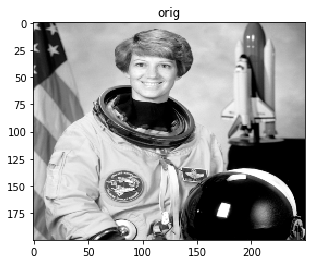

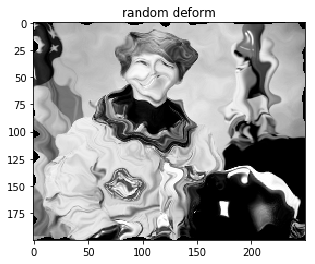

In [17]:
im_interped = im_deformer.apply_random_disps()

# show images
plt.figure(1)
plt.imshow(im[:, :, 0], cmap='gray')
plt.title('orig')

plt.figure(2)
plt.imshow(im_interped, cmap='gray')
plt.title('random deform')

plt.show()